# 1. Przetwarzanie sygnałów

*   Wczytaj plik dźwiękowy audio.wav

In [1]:
from IPython.display import Audio
from scipy.io.wavfile import read as audioread
from scipy.io.wavfile import write as audiowrite

# Wczytaj plik dźwiękowy audio.wav
# Read audio file
sampling_frequency, signal = audioread("audio.wav")

* Wstaw widget z audioplayerem tak, aby można było odsłuchać plik

In [2]:
# Generate a player for mono sound
print("Here is audio widget.")
Audio(signal, rate=sampling_frequency, autoplay=False)

Here is audio widget.


* Narysuj oscylogram

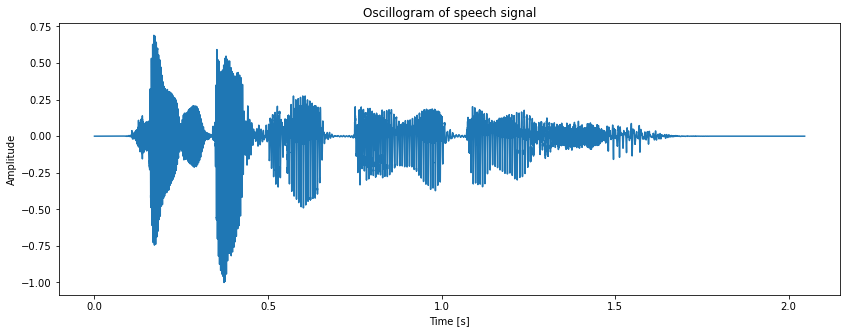

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def normalise(data):
    """
    Process of normalising input amplitude
    """
    normalised_data = data / np.max(np.abs(data))
    return normalised_data


signal_normalised = normalise(signal)

length = signal_normalised.shape[0] / sampling_frequency

# plotting oscillogram
time = np.linspace(0.0, length, signal_normalised.shape[0])
plt.figure(figsize=(14, 5))
plt.plot(time, signal_normalised)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Oscillogram of speech signal")
plt.show()

* Wyznacz i narysuj przebieg tonu podstawowego F0

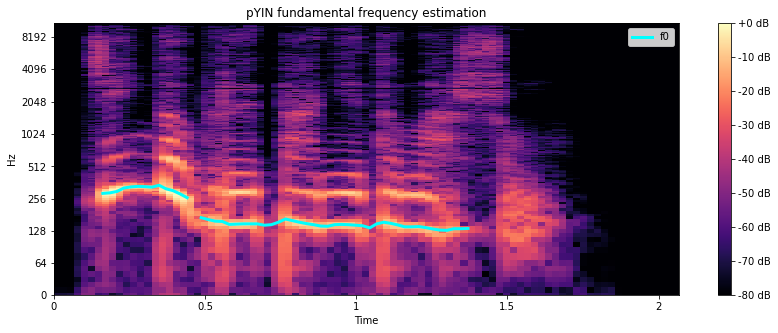

In [4]:
# using librosa

import librosa
import librosa.display
import matplotlib.pyplot as plt

signal, _ = librosa.load("audio.wav")
f0, voiced_flag, voiced_probs = librosa.pyin(
    signal, fmin=librosa.note_to_hz("C2"), fmax=librosa.note_to_hz("C7")
)
times = librosa.times_like(f0)

amplitude_db = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
fig, ax = plt.subplots(figsize=(14, 5))
img = librosa.display.specshow(amplitude_db, x_axis="time", y_axis="log", ax=ax)
ax.set(title="pYIN fundamental frequency estimation")
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label="f0", color="cyan", linewidth=3)
legend = ax.legend(loc="upper right")
plt.show()

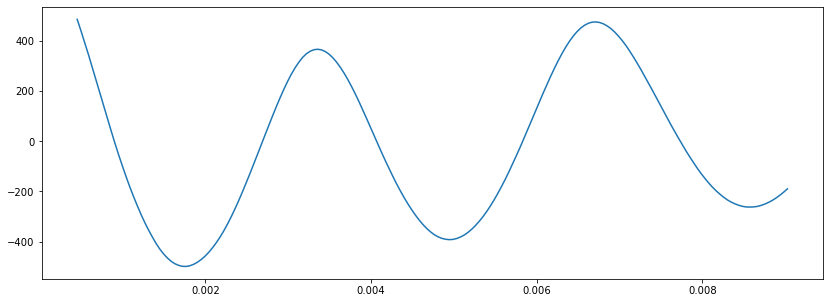

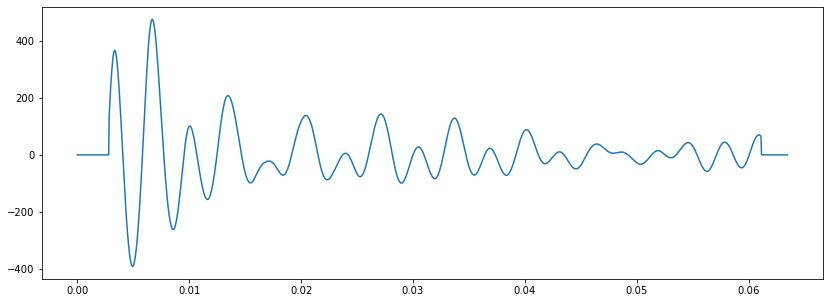

Estimated f0 (autocorrelation method) = 148.99


In [5]:
# autocorrelation method

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

signal, samplerate = librosa.load("audio.wav")
length = signal.shape[0] / samplerate
samples = int(samplerate * length)
time = np.arange(samples) / samplerate
autocorrelated_signal = librosa.autocorrelate(signal, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(time[10:200], autocorrelated_signal[10:200])

midi_hi = 65.0
midi_lo = 12.0
frequency_hi = librosa.midi_to_hz(midi_hi)
frequency_lo = librosa.midi_to_hz(midi_lo)
time_lo = samplerate / frequency_hi
time_hi = samplerate / frequency_lo

autocorrelated_signal[: int(time_lo)] = 0
autocorrelated_signal[int(time_hi) :] = 0
plt.figure(figsize=(14, 5))
plt.plot(time[:1400], autocorrelated_signal[:1400])
plt.show()
time_max = autocorrelated_signal.argmax()
f0_autocorrelation = samplerate / time_max
print(f"Estimated f0 (autocorrelation method) = {f0_autocorrelation:.2f}")

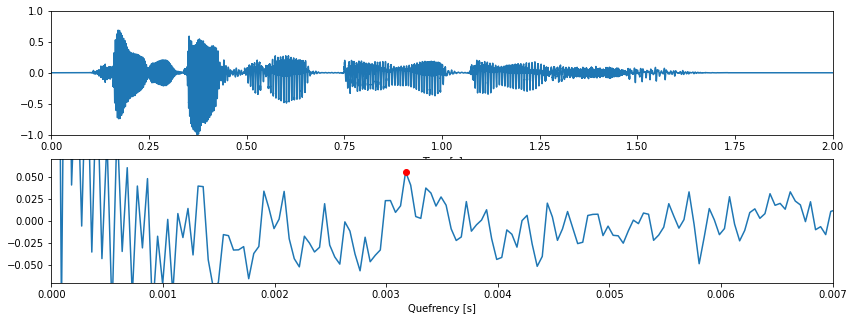

Estimated f0 (cepstrum method): 315.00


In [6]:
# Cepstrum
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read as audioread


def cepstrum(signal):
    spectrum = np.fft.fft(signal)
    ceps = np.fft.ifft(np.log(np.abs(spectrum))).real
    return ceps


samplerate, signal = audioread("audio.wav")
length = signal.shape[0] / samplerate
samples = samplerate * length
time = np.arange(samples) / samplerate

ceps = cepstrum(signal_normalised)

fig = plt.figure(figsize=(14, 5))
ax0 = fig.add_subplot(211)
ax0.plot(time, signal_normalised)
ax0.set_xlabel("Time [s]")
ax0.set_xlim(0, 2)
ax0.set_ylim(-1, 1)
ax1 = fig.add_subplot(212)
ax1.set_xlabel("Quefrency [s]")
ax1.set_xlim(0.00, 0.007)
ax1.set_ylim(-0.07, 0.07)
ax1.plot(time[0:500], ceps[0:500])
id_of_maximum = np.argmax(ceps[20:150]) + 20
f0_cepstrum = samplerate / id_of_maximum
ax1.plot(time[id_of_maximum], ceps[id_of_maximum], "or")
plt.show()
print(f"Estimated f0 (cepstrum method): {f0_cepstrum:.2f}")

Zaimplementowano dwie metody wyznaczania f0 - cepstrum i autokorelację. W obu przypadkach otzymano różne wyniki. Bazując jednak na przebiegu f0 wyznaczonym przy pomocy biblioteki *librosa* można stwierdzić, że obie są poprawne. Pierwsze 0,5 sekundy nagrania (*"Dzień dobry"*) jest wypowiedziane wyższym tonem, jako zagajenie do rozmowy. Pozostała część wypowiedziana została spokojniej, niższym tonem. Aby ocenić f0 jednoznacznie potrzeba nagrania o mniejszej dynamice, być może dłuższego.

* Wyznacz i narysuj w skali decybelowej krótkoczasowe widmo sygnału (STFT). Dobierz odpowiednie wg Ciebie parametry analizy. Uzasadnij swój wybór.

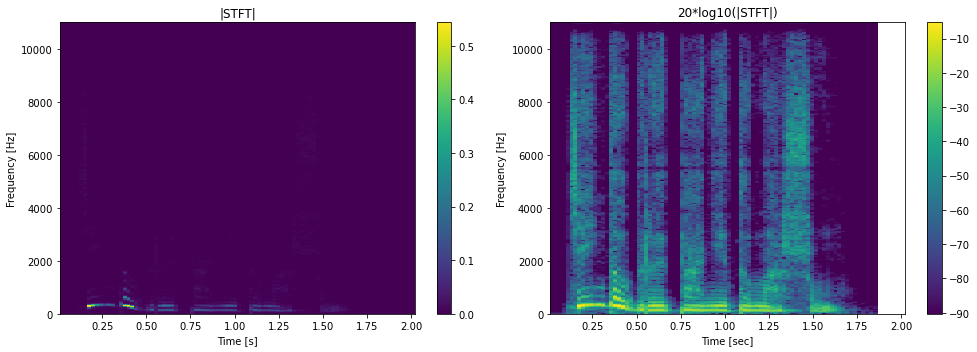

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as ssignal


def normalise(data):
    normalised_data = data / np.max(np.abs(data))
    return normalised_data


def plot_stft(time, frequency, matrix, title):
    """
    Function that plots matrix in linear and logarithmic (dB) scale
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    im1 = ax[0].pcolormesh(time, frequency, abs(matrix))
    ax[0].set_title(f"|{title}|")
    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Frequency [Hz]")
    fig.colorbar(im1, ax=ax[0])

    with np.errstate(divide="ignore"):
        im1 = ax[1].pcolormesh(
            time,
            frequency,
            20 * np.log10(np.abs(matrix)),
            vmin=20 * np.log10(2 ** (-15)),
        )
    ax[1].set_title(f"20*log10(|{title}|)")
    ax[1].set_xlabel("Time [sec]")
    ax[1].set_ylabel("Frequency [Hz]")
    fig.colorbar(im1, ax=ax[1])
    fig.tight_layout()
    plt.show()

    
# Load input signal
sampling_frequency, signal = audioread("audio.wav")

signal_normalised = normalise(signal)

# Calculate STFT
frequency, time, STFT = ssignal.stft(
    signal_normalised,
    sampling_frequency,
    window="hanning",
    nperseg=512,
    noverlap=20,
    padded=False,
    boundary=None,
)
# padded, boundary->complex in spectrogram
STFT = STFT * 2
plot_stft(time, frequency, STFT, "STFT")

# Uzasadnienie wybranych parametrów.
Im większą długość próbki sygnału przyjmiemy przy tworzeniu widma (parametr *nperseg*), tym lepszą uzyskamy jego rozdzielczość w częstotliwości (lepsze rozseparowanie pików harmonicznych). Spektrogram uzyskany z takich widm będzie cechował się jednak dużym odstęp czasu pomiędzy kolejnymi widmami, co spowoduje, że jego rozdzielczość czasowa będzie mała. I odwrotnie – stosując bardzo krótkie próbki do stworzenia widma, uzyskamy doskonałą rozdzielczość czasową, a gorszą częstotliwościową. Niestety, nie da się pogodzić obu tych wymagań.
Parametr *noverlap* jak nazwa wskazuje mówi, ile próbek się nakłada (overlap), więc kolejne ramki występują co *nperseg* -*noverlap* próbek. 

Dobrano parametry w taki sposób, aby uzyskać pewien kompromis pomiędzy sensowną rodzielczością czasową a częstotliwościową.

Funkcja STFT normalizuje macierz dzieląc wartości prążków bezpośrednio z definicji DFT przez długość ramki. Ponieważ sygnał był rzeczywisty to widmo amplitudowe jest parzyste i stąd amplituda pojedynczego prążka jest równa 0.5 a nie 1, więc należy podwoić wartości STFT w celu otrzymania poprawnych amplitud.

*   Wyznacz i narysuj w skali decybelowej wartości MFCC (13 współczynników). Parametry analizy pozostaw takie jak w kroku poprzednim.

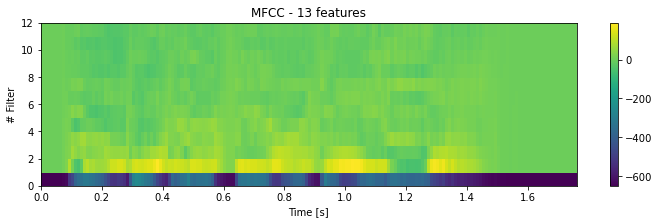

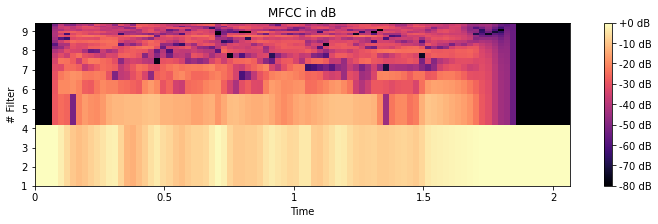

In [8]:
import librosa
import matplotlib.pyplot as plt
import numpy as np


def plot_2d(time, frequency, data, title, y_label):
    """
    Calculate MFCC for audio
    """
    fig = plt.figure(figsize=(12, 3))
    im1 = plt.pcolormesh(time, frequency, data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel(y_label)
    fig.colorbar(im1)

    
data, samplerate = librosa.load("audio.wav")

mfcc = []

mfcc = librosa.feature.mfcc(data, sr=samplerate, n_mfcc=13, n_fft=512, hop_length=256).T

plot_2d(
    np.arange(0, np.shape(mfcc)[0]) * 0.01,
    np.arange(0, np.shape(mfcc)[1]),
    mfcc.T,
    "MFCC - 13 features",
    "# Filter"
)


fig, ax = plt.subplots(figsize=(12, 3))
data_db = librosa.amplitude_to_db(np.abs(librosa.feature.mfcc(data)), ref=np.max)
img = librosa.display.specshow(data_db, y_axis='log', x_axis='time',
                               sr=samplerate, ax=ax)
ax.set(title='MFCC in dB')
ax.set_ylabel("# Filter")
ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
ax.label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")

# 2 Metryki
W pliku predicted.json zapisane są wyniki rozpoznania systemu ASR, służącego do rozpoznawania cyfr.

Dla każdej cyfry od 0 do 9 w słowniku przedstawione są wartości, jakie system rozpoznał dla kolejnych nagrań danej cyfry.

Oblicz i przedstaw w formie tabeli macierz pomyłek (confusion matrix) oraz oblicz skuteczność systemu.

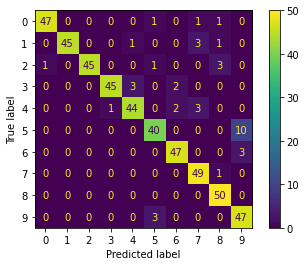

In [9]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

results_filename = "predicted.json"

with open(results_filename) as f:
    data = json.load(f)

values = []
predictions = []
labels = []

for number in data.keys():
    labels.append(int(number))
    for prediction in data[number]:
        values.append(int(number))
        predictions.append(int(prediction))

matrix = confusion_matrix(values, predictions)

# result visualization
vis = ConfusionMatrixDisplay(matrix, display_labels=labels)
vis.plot()

In [10]:
from sklearn.metrics import accuracy_score, f1_score

# skutecznosc systemu
eval_accu = accuracy_score(values, predictions)
eval_f1 = f1_score(values, predictions, average="macro")
print(f"Classification accuracy based on '{results_filename}': {100*eval_accu:.2f}%")
print(f"Classification F1-score based on '{results_filename}': {eval_f1:.3f}")

Classification accuracy based on 'predicted.json': 91.80%
Classification F1-score based on 'predicted.json': 0.918


# 3 Macierze

In [11]:
import numpy as np

P = []
with open("matrix_P.txt", "r") as f:
    for line in f:
        num_line = []
        for number in line:
            if number.isnumeric():
                num_line.append(float(number))
        P.append(num_line)

Q = []
with open("matrix_Q.txt", "r") as f:
    for line in f:
        num_line = []
        for number in line:
            if number.isnumeric():
                num_line.append(float(number))
        Q.append(num_line)

P = np.array(P)
Q = np.array(Q)

transposed_P = np.transpose(P)
transposed_Q = np.transpose(Q)

mean_P = np.transpose(np.matrix(np.mean(P, axis=0)))
mean_Q = np.transpose(np.matrix(np.mean(Q, axis=0)))

covariance_P = np.cov(np.transpose(P))
covariance_Q = np.cov(np.transpose(Q))

covariance_P1 = np.linalg.pinv(covariance_P)
covariance_Q1 = np.linalg.pinv(covariance_Q)

sum = np.dot((covariance_P1 + covariance_Q1), (mean_P - mean_Q))
sum = np.dot(sum, np.transpose(mean_P - mean_Q))
sum = (
    sum
    + np.dot(covariance_P, covariance_Q1)
    + np.dot(covariance_Q, covariance_P1)
    - 2 * np.identity(4)
)

result = np.trace(sum) / 2

print(f"The result: {result}")

The result: 6.033482453811376
